Loaded embeddings for 835 entities
Loaded Y data with 1075 rows

Dataset split based on selectivity_ee_percent >= 80:
Training set size: 694 samples
Test set size: 356 samples
Percentage of data in test set: 33.90%
Fitting started...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__learning_rate=0.0018329807108324356, model__max_depth=4, model__max_features=0.49688201579633756, model__max_leaf_nodes=None, model__min_weight_fraction_leaf=0.43023780435135606, model__n_estimators=700, model__subsample=0.7777777777777778; neg_mean_absolute_error: (test=-0.327) r2: (test=0.143) total time= 2.7min
[CV 2/5] END model__learning_rate=0.0018329807108324356, model__max_depth=4, model__max_features=0.49688201579633756, model__max_leaf_nodes=None, model__min_weight_fraction_leaf=0.43023780435135606, model__n_estimators=700, model__subsample=0.7777777777777778; neg_mean_absolute_error: (test=-0.261) r2: (test=0.249) total time= 2.7min
[CV 4/5] END model__learning_ra

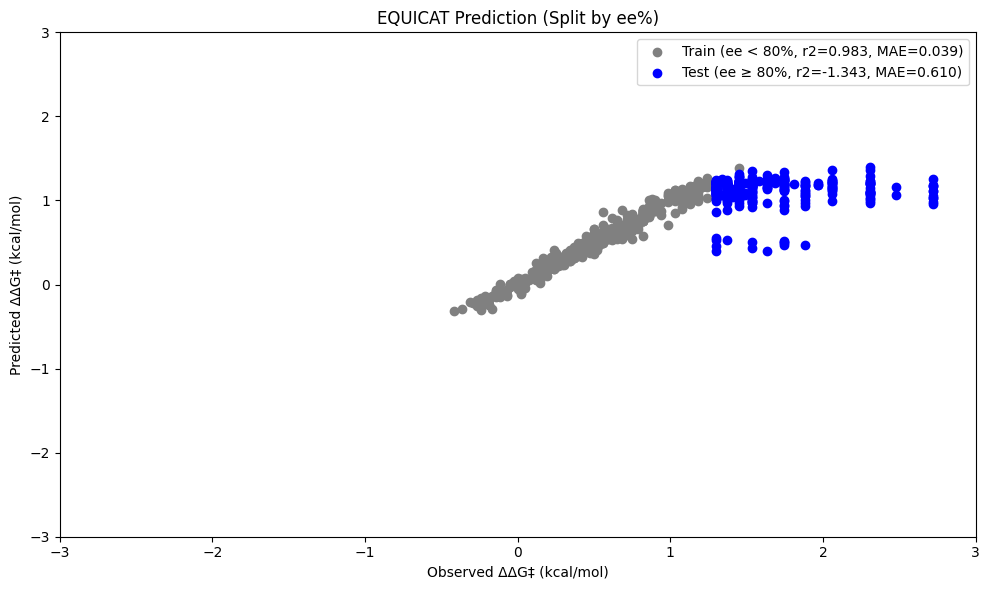

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from time import time
import re
import yaml

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Function to load embeddings from JSON file and strip family prefix
def load_embeddings(file_path):
    with open(file_path, 'r') as f:
        raw_embeddings = json.load(f)
    
    embeddings = {}
    family_pattern = re.compile(r'^family\d+_')
    for key, value in raw_embeddings.items():
        stripped_key = family_pattern.sub('', key)
        embeddings[stripped_key] = np.array(value)
    
    return embeddings

# Load embeddings
embeddings = load_embeddings('/Users/utkarsh/MMLI/equicat/develop_op/final_molecule_embeddings.json')
print(f"Loaded embeddings for {len(embeddings)} entities")

# Load Y data
Y_df = pd.read_csv('/Users/utkarsh/MMLI/equicat/science/Y_DATA.csv', dtype={
    'catalyst_id': str,
    'imine_id': str,
    'thiol_id': str,
    'product_id': str
})
print(f"Loaded Y data with {len(Y_df)} rows")

# Create X data and Y data while keeping track of selectivity_ee_percent
X_data = []
Y_data = []
ee_values = []  # Store selectivity_ee_percent values

for _, row in Y_df.iterrows():
    catalyst_id = row['catalyst_id']
    imine_id = row['imine_id']
    thiol_id = row['thiol_id']
    product_id = row['product_id']
    
    if all(id in embeddings for id in [catalyst_id, imine_id, thiol_id, product_id]):
        combined_embedding = np.concatenate([
            embeddings[catalyst_id],
            embeddings[imine_id],
            embeddings[thiol_id],
            embeddings[product_id]
        ])
        X_data.append(combined_embedding)
        Y_data.append(row['selectivity_ddGact_kcal'])
        ee_values.append(row['selectivity_ee_percent'])

# Convert to numpy arrays for easier handling
X_data = np.array(X_data)
Y_data = np.array(Y_data)
ee_values = np.array(ee_values)

# Create train-test split based on selectivity_ee_percent
test_mask = ee_values >= 80
train_mask = ~test_mask

X_train = X_data[train_mask]
X_test = X_data[test_mask]
Y_train = Y_data[train_mask]
Y_test = Y_data[test_mask]

print(f"\nDataset split based on selectivity_ee_percent >= 80:")
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Percentage of data in test set: {(len(X_test)/len(X_data))*100:.2f}%")

# Set up the model pipeline
seed = 15671 // 2
np.random.seed(seed)

f_select_model = RandomForestRegressor(n_estimators=1000, n_jobs=64, random_state=1234)

pipe_random = Pipeline(steps=[
    ('preprocess', VarianceThreshold(1e-3)),
    ('feature_selection', SelectFromModel(f_select_model, max_features=30)),
    ('model', GradientBoostingRegressor(n_estimators=500, learning_rate=0.01))
])

param_dict = {
    'model__learning_rate': np.logspace(-4, 0, 20),
    'model__subsample': np.linspace(0.5, 1.0, 10),
    'model__min_weight_fraction_leaf': (np.random.uniform(0.0, .5,20)),
    'model__max_depth': [3,4,5,6,7,8,9,10,None],
    'model__max_features': (np.random.uniform(0.01, .99,20)),
    'model__max_leaf_nodes': [10,100,1000,None],
    'model__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

search = RandomizedSearchCV(pipe_random, cv=5, param_distributions=param_dict,
                          n_iter=100, n_jobs=64, verbose=3, refit='neg_mean_absolute_error',
                          scoring=['neg_mean_absolute_error', 'r2'])

t0 = time()
print("Fitting started...")
search = search.fit(X_train, Y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

best_model = search.best_estimator_

print("\nBest parameters found:")
for param, value in search.best_params_.items():
    print(f"{param}: {value}")

# Evaluate model performance
Y_pred_train = best_model.predict(X_train)
Y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(Y_train, Y_pred_train)
train_mae = mean_absolute_error(Y_train, Y_pred_train)
test_r2 = r2_score(Y_test, Y_pred_test)
test_mae = mean_absolute_error(Y_test, Y_pred_test)

print(f"\nModel Performance:")
print(f"Train R^2: {train_r2:.5f}, train MAE: {train_mae:.5f}")
print(f"Test R^2: {test_r2:.5f}, test MAE: {test_mae:.5f}")

# Plotting function
def plot_and_print(estimator, X_train, Y_train, X_test, Y_test, title, verbose=1, file_dpi=800):
    predicted_train = estimator.predict(X_train)
    r2_train = r2_score(Y_train, predicted_train)
    mae_train = mean_absolute_error(Y_train, predicted_train)

    predicted_test = estimator.predict(X_test)
    r2_test = r2_score(Y_test, predicted_test)
    mae_test = mean_absolute_error(Y_test, predicted_test)

    if verbose:
        print("\n" + title)
        print(f"Train R^2: {r2_train:0.5f}, train MAE: {mae_train:0.5f}")
        print(f"Test R^2: {r2_test:0.5f}, test MAE: {mae_test:0.5f}")
    
    fig, ax = plt.subplots(figsize=(10, 6))

    train_plot = ax.scatter(
        Y_train,
        predicted_train,
        color="gray",
        label=f"Train (ee < 80%, r2={r2_train:0.3f}, MAE={mae_train:0.3f})"
    )

    test_plot = ax.scatter(
        Y_test,
        predicted_test,
        color="blue",
        label=f"Test (ee ≥ 80%, r2={r2_test:0.3f}, MAE={mae_test:0.3f})"
    )

    ax.set_title(title)
    ax.set_xlabel("Observed ΔΔG‡ (kcal/mol)")
    ax.set_ylabel("Predicted ΔΔG‡ (kcal/mol)")
    ax.set_ylim(-3, 3)
    ax.set_xlim(-3, 3)
        
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + "_ee_split.png", dpi=file_dpi)
    plt.show()
    plt.close()

# Plot results
print("\nPlotting results...")
plot_and_print(best_model, X_train, Y_train, X_test, Y_test, "EQUICAT Prediction (Split by ee%)")

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from time import time
import re

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Constants
RANDOM_SEED = 15671 // 2
np.random.seed(RANDOM_SEED)

def load_embeddings(file_path):
    """Load embeddings from JSON file and strip family prefix."""
    with open(file_path, 'r') as f:
        raw_embeddings = json.load(f)
    
    embeddings = {}
    family_pattern = re.compile(r'^family\d+_')
    for key, value in raw_embeddings.items():
        stripped_key = family_pattern.sub('', key)
        embeddings[stripped_key] = np.array(value)
    
    return embeddings

def prepare_data(embeddings_path, y_data_path):
    """Prepare X and Y data with scaling."""
    # Load embeddings
    embeddings = load_embeddings(embeddings_path)
    print(f"Loaded embeddings for {len(embeddings)} entities")

    # Load Y data
    Y_df = pd.read_csv(y_data_path, dtype={
        'catalyst_id': str,
        'imine_id': str,
        'thiol_id': str,
        'product_id': str
    })
    print(f"Loaded Y data with {len(Y_df)} rows")

    # Create X data and Y data
    X_data = []
    Y_data = []
    valid_indices = []

    for idx, row in Y_df.iterrows():
        catalyst_id = row['catalyst_id']
        imine_id = row['imine_id']
        thiol_id = row['thiol_id']
        product_id = row['product_id']
        
        if all(id in embeddings for id in [catalyst_id, imine_id, thiol_id, product_id]):
            combined_embedding = np.concatenate([
                embeddings[catalyst_id],
                embeddings[imine_id],
                embeddings[thiol_id],
                embeddings[product_id]
            ])
            X_data.append(combined_embedding)
            Y_data.append(row['selectivity_ddGact_kcal'])
            valid_indices.append(idx)

    X_data = np.array(X_data)
    Y_data = np.array(Y_data)

    # Scale Y data
    scaler = MinMaxScaler()
    Y_scaled = scaler.fit_transform(Y_data.reshape(-1, 1)).flatten()

    # Calculate 80th percentile of scaled ddG values
    threshold = np.percentile(Y_scaled, 80)
    
    # Create train-test split based on 80th percentile
    test_mask = Y_scaled >= threshold
    train_mask = ~test_mask

    X_train = X_data[train_mask]
    X_test = X_data[test_mask]
    Y_train = Y_data[train_mask]  # Use original (unscaled) Y values
    Y_test = Y_data[test_mask]    # Use original (unscaled) Y values

    print(f"\nDataset split based on 80th percentile of scaled ddG values:")
    print(f"Training set size: {len(X_train)} samples")
    print(f"Test set size: {len(X_test)} samples")
    print(f"Percentage of data in test set: {(len(X_test)/len(X_data))*100:.2f}%")

    return X_train, X_test, Y_train, Y_test

def create_model():
    """Create and configure the ML pipeline."""
    f_select_model = XGBRegressor(
        n_estimators=1000,
        n_jobs=64,
        random_state=RANDOM_SEED
    )

    pipe = Pipeline(steps=[
        ('preprocess', VarianceThreshold(1e-3)),
        ('feature_selection', SelectFromModel(f_select_model, max_features=30)),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            random_state=RANDOM_SEED,
            n_jobs=64,
            tree_method='hist'
        ))
    ])

    param_dict = {
        # Basic parameters
        'model__learning_rate': np.logspace(-4, -1, 20),
        'model__n_estimators': [100, 200, 300, 400, 500, 750, 1000],
        'model__max_depth': [3, 4, 5, 6, 7, 8],
        
        # Sampling parameters
        'model__subsample': np.linspace(0.6, 1.0, 5),
        'model__colsample_bytree': np.linspace(0.6, 1.0, 5),
        
        # Regularization parameters
        'model__reg_alpha': np.logspace(-4, 1, 10),
        'model__reg_lambda': np.logspace(-4, 1, 10),
        'model__min_child_weight': [1, 2, 3, 4, 5],
        'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    }

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dict,
        n_iter=50,
        cv=5,
        n_jobs=64,
        verbose=3,
        scoring=['neg_mean_absolute_error', 'r2'],
        refit='neg_mean_absolute_error',
        random_state=RANDOM_SEED
    )

    return search

def plot_and_print(estimator, X_train, Y_train, X_test, Y_test, title, verbose=1, file_dpi=800):
    """Plot and print model results."""
    predicted_train = estimator.predict(X_train)
    r2_train = r2_score(Y_train, predicted_train)
    mae_train = mean_absolute_error(Y_train, predicted_train)

    predicted_test = estimator.predict(X_test)
    r2_test = r2_score(Y_test, predicted_test)
    mae_test = mean_absolute_error(Y_test, predicted_test)

    if verbose:
        print("\n" + title)
        print(f"Train R^2: {r2_train:0.5f}, train MAE: {mae_train:0.5f}")
        print(f"Test R^2: {r2_test:0.5f}, test MAE: {mae_test:0.5f}")
    
    fig, ax = plt.subplots(figsize=(10, 6))

    train_plot = ax.scatter(
        Y_train,
        predicted_train,
        color="gray",
        label=f"Train (Lower 80%, r2={r2_train:0.3f}, MAE={mae_train:0.3f})"
    )

    test_plot = ax.scatter(
        Y_test,
        predicted_test,
        color="blue",
        label=f"Test (Top 20%, r2={r2_test:0.3f}, MAE={mae_test:0.3f})"
    )

    ax.set_title(title)
    ax.set_xlabel("Observed ΔΔG‡ (kcal/mol)")
    ax.set_ylabel("Predicted ΔΔG‡ (kcal/mol)")
    ax.set_ylim(-3, 3)
    ax.set_xlim(-3, 3)
        
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + "_ddG_percentile_split.png", dpi=file_dpi)
    plt.show()
    plt.close()

Loaded embeddings for 835 entities
Loaded Y data with 1075 rows

Dataset split based on 80th percentile of scaled ddG values:
Training set size: 814 samples
Test set size: 236 samples
Percentage of data in test set: 22.48%
Fitting started...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.06951927961775606, model__max_depth=4, model__min_child_weight=1, model__n_estimators=200, model__reg_alpha=0.0001, model__reg_lambda=0.05994842503189409, model__subsample=0.6; neg_mean_absolute_error: (test=-0.292) r2: (test=0.229) total time=  48.7s
[CV 1/5] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.06951927961775606, model__max_depth=4, model__min_child_weight=1, model__n_estimators=200, model__reg_alpha=0.0001, model__reg_lambda=0.05994842503189409, model__subsample=0.6; neg_mean_absolute_error: (test=-0.356) r2: (test=0.148) total time=  49.1s
[CV 1/5] END model__colsam

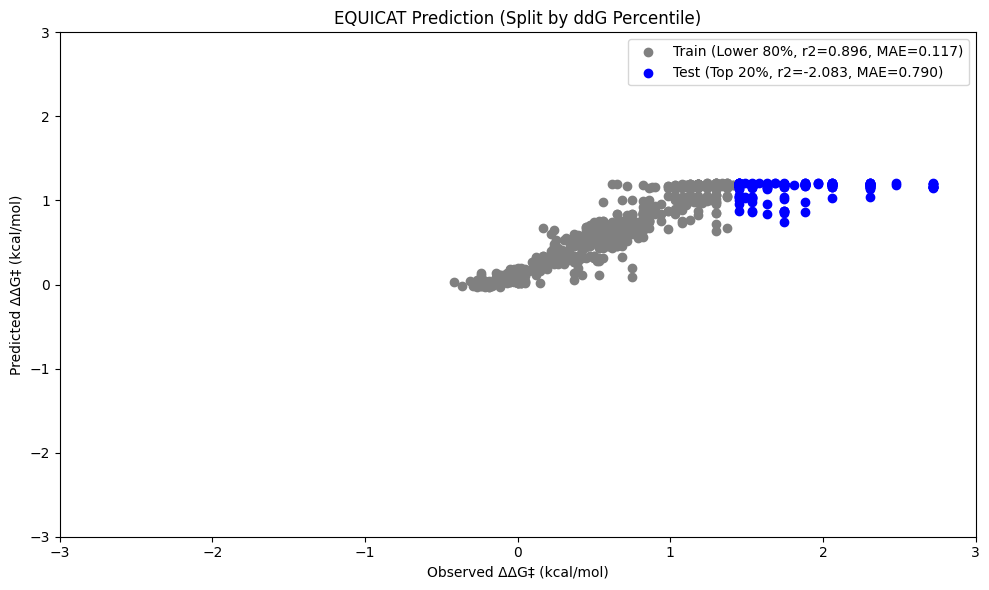

In [4]:
def main():
    # File paths
    embeddings_path = '/Users/utkarsh/MMLI/equicat/develop_op/final_molecule_embeddings.json'
    y_data_path = '/Users/utkarsh/MMLI/equicat/science/Y_DATA.csv'

    # Prepare data
    X_train, X_test, Y_train, Y_test = prepare_data(embeddings_path, y_data_path)

    # Create and train model
    search = create_model()
    
    print("Fitting started...")
    t0 = time()
    search = search.fit(X_train, Y_train)
    print(f"Fitting took {time() - t0:0.3f}s.")

    best_model = search.best_estimator_

    print("\nBest parameters found:")
    for param, value in search.best_params_.items():
        print(f"{param}: {value}")

    # Evaluate and visualize results
    Y_pred_train = best_model.predict(X_train)
    Y_pred_test = best_model.predict(X_test)

    train_r2 = r2_score(Y_train, Y_pred_train)
    train_mae = mean_absolute_error(Y_train, Y_pred_train)
    test_r2 = r2_score(Y_test, Y_pred_test)
    test_mae = mean_absolute_error(Y_test, Y_pred_test)

    print(f"\nModel Performance:")
    print(f"Train R^2: {train_r2:.5f}, train MAE: {train_mae:.5f}")
    print(f"Test R^2: {test_r2:.5f}, test MAE: {test_mae:.5f}")

    plot_and_print(best_model, X_train, Y_train, X_test, Y_test, 
                  "EQUICAT Prediction (Split by ddG Percentile)")

if __name__ == "__main__":
    main()